<a href="https://colab.research.google.com/github/aeirya/information-retrieval-course/blob/master/hw1/information_retrieval_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [1]:
# setup colab drive
from google.colab import drive
drive.mount('/content/drive/')

dir = '/content/drive/MyDrive/Assignment/InformationRetrieval/hw1/dataset/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# let's import needed libraries
import spacy
import pandas as pd
import numpy as np
from numpy.linalg import norm

In [3]:
# read csv files
def read_file(filename):
  return pd.read_csv(dir + filename)

docs = read_file('hw1_docs.csv')
queries = read_file('hw1_queries.csv')
qrels = read_file('hw1_qrels.csv')

In [4]:
# text preprocessing
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    # dropping stop words and punctuations
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

In [5]:
docs['processed_doc'] = docs['document'].apply(preprocess)

In [6]:
queries['processed_query'] = queries['query'].apply(preprocess)

### Getting Familiar with the data

## TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# here I prefered using nonbinary vectorizer to get better results
vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,1), max_df=0.8, token_pattern='\w*[a-z]+\w*')

# now lets fetch embed documents and queries

# documents tfidf matrix
D = vectorizer.fit_transform(docs['processed_doc'])

# queries' tfidf matrix
Q = vectorizer.transform(queries['processed_query'])

D.shape
# you could see the vector size is bigger than 1000

(750, 3030)

In [8]:
vocab = vectorizer.get_feature_names_out()
vocab

array(['11th', '15th', '1st', ..., 'zoonotic', 'µm', 'μg'], dtype=object)

In [9]:
# since we're just ranking similarities, the size of a query vector is not needed, then we're not gonna use this function here
def cosine_sim(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

norm = np.linalg.norm(D.toarray(), ord=2, axis=1)
norm[0:5]
# it also seems the document embedding vectors are already normal so no need to normalize here

array([1., 1., 1., 1., 1.])

In [10]:
# similarity matrix of querries to documents
sim_matrix = Q @ D.T
sim_matrix.shape

(50, 750)

In [11]:
# top 10 for each query
best = np.argpartition(sim_matrix.toarray(), -10, axis=1)[:, -10:]
best.shape

(50, 10)

#### Gold related documents

In [12]:
qrels

,query_id,doc_id
0,1,005b2j4b
1,1,0chuwvg6
2,1,0t2a5500
3,1,0y34yxlb
4,1,105q161g
...,...,...
745,50,xhm97wy2
746,50,xieqswct
747,50,y87tq9wu
748,50,ygwdldae


In [13]:
series = pd.Series(qrels['query_id'])
print(series.searchsorted(2))
print(series.searchsorted(3))
# it seems the qrels data provides 15 best documents for each query

15
30


In [14]:
doc_id_to_index = {}
for i, doc_id in enumerate(docs['doc_id']):
  doc_id_to_index[doc_id] = i

def doc_index(doc_id):
  return doc_id_to_index[doc_id]

In [15]:
def gold_related_docs(qid):
  '''
  qid: query id
  '''
  related_ids = qrels['doc_id'][qid*15:(qid+1)*15]
  return np.array([doc_index(id) for id in related_ids])

gold_best = np.zeros((len(queries), 15)).astype(int)
for q in range(len(queries)):
  gold_best[q, :] = gold_related_docs(q)



array([[502, 736,  20, 255, 748, 199, 597, 609, 490, 425, 742, 396, 512,
        286, 634],
       [531, 602, 285, 264, 221, 717, 139, 702, 150, 495, 261, 642, 576,
        592, 601],
       [586, 579, 136, 510, 126, 514, 485, 172,  75, 239, 693, 134, 699,
        732, 603]])

In [182]:
gold_best[0:3]

array([[502, 736,  20, 255, 748, 199, 597, 609, 490, 425, 742, 396, 512,
        286, 634],
       [531, 602, 285, 264, 221, 717, 139, 702, 150, 495, 261, 642, 576,
        592, 601],
       [586, 579, 136, 510, 126, 514, 485, 172,  75, 239, 693, 134, 699,
        732, 603]])

In [16]:
best[0:3]

array([[396, 748, 609, 435, 637, 389, 742, 557, 668, 425],
       [104, 556, 168, 384, 701, 264, 642, 601,  70, 139],
       [667, 485, 253, 172,  14, 281, 235, 586, 297,  38]])

#### Check correctness of results

In [17]:
result = np.ones_like(best)
for q in range(len(queries)):
  wrong_idx = np.setdiff1d(best[q, :], gold_related_docs(q))
  result[q, :] = np.where(np.isin(best[q], wrong_idx), 0, result[q])

tf_idf_result = np.array(result)
result[0:3]

array([[1, 1, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]])

## BIM

In [18]:
# perpare data

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, token_pattern='\w*[a-z]+\w*', min_df=3, max_df=0.8)

D = vectorizer.fit_transform(docs['processed_doc'])
Q = vectorizer.transform(queries['processed_query'])

vocab = vectorizer.get_feature_names_out()
vocab_size = len(vocab)

In [19]:
# df_t: the number of dumments that contain term t
dft = D.sum(axis=0)[0]

N = D.shape[1]
ut = dft/N

iut = 1/ut

We have RSV_d = sum_{t: x_t = q_t = 1} log([p_t/(1-p_t)] * [(1-u_t)/u_t]) = sum log([X] * [iut]) = sum log (r)

Notice that (1-ut)/ut = (N - df)/df ~ N/df = 1/ut = iut

NOTE: since we KNOW that we are going to redo some calculations between queries, I'm going to aggregate the vocab of all queries first to do some optimization and calculate pt/(1-pt) for the needed terms

In [20]:
# the terms that appear in queries
t = Q.sum(axis=0) > 0

In [148]:
def top10matrix(score_matrix):
  '''
  score_matrix: Q -> D
  top 10 document for each query
  '''

  return np.argpartition(score_matrix, -10, axis=1)[:, -10:]


def correctness_matrix(best):
  '''
  reports correctness of the 'best' matrix with a matrix of zeros and ones of the same size
  '''

  result = np.ones_like(best)

  # number of queries
  nQ = best.shape[0]

  for q in range(nQ):
    wrong_idx = np.setdiff1d(best[q, :], gold_related_docs(q))
    result[q, :] = np.where(np.isin(best[q], wrong_idx), 0, result[q])

  return np.array(result)


def cmap(scores):
  '''
  scores -> correctness matrix of the best scores
  '''

  return correctness_matrix(top10matrix(scores))

In [180]:
def calc_X(p):
  return np.ones((1,vocab_size)) * p/(1-p)

def f(p):
  X = calc_X(p)
  return np.where(t, np.log(np.multiply(X, iut)), 0)[0]

Da = D.toarray()
Qa = Q.toarray()

# BIM_results = {}
BIM_scores = {}

for p in [0.3, 0.5, 0.7]:
  r = f(p)

  scores = np.zeros((Q.shape[0], D.shape[0]))
  # todo: optimize
  for d in range(D.shape[0]):
    for q in range(Q.shape[0]):
      scores[q,d] = r[(Da[d] > 0) & (Qa[q] > 0)].sum()

  # BIM_results[p] = correctness_matrix(top10matrix(scores))
  BIM_scores[p] = scores

In [181]:
# BIM_results[0.5][0:3]

## BM25

In [38]:
vectorizer = CountVectorizer(binary=False, token_pattern='\w*[a-z]+\w*', min_df=3, max_df=0.8)

D = vectorizer.fit_transform(docs['processed_doc'])
Q = vectorizer.transform(queries['processed_query'])

In [126]:
# convert sparse matrices to term existence masks
Qt = Q.toarray() > 0

Da = D.toarray()

Document Score:
∑_{t∈q} log (N/dft) (k1+1)tf / [k1((1-b)+b(Ld/Lave))+tf]

∑log iut A / B

In [133]:
def bm25(D, Q, Da, Qt, k, b):
  # document length
  Ld = D.sum(axis=1)
  # average document length
  Lave = Ld.mean()

  L = Ld/Lave

  nQ = Q.shape[0]
  nD = D.shape[0]
  scores = np.zeros((nQ, nD))

  for q in range(nQ):
    for d in range(nD):

      # mask
      m = Qt[q]

      logiut = np.array(np.log(iut[0,m]).T)[:, 0]

      # term frequencies in the document
      tf = Da[d, m]


      A = (k+1) * tf
      B = tf + k*(1 - b + b * L[d,0])

      scores[q,d] = (logiut * A/B).sum()

  return scores

#### Hyperparameters
Now lets choose best hyperparameters k and b

In [164]:
K = np.linspace(0.6, 2.4, num=10)
B = np.linspace(0.3, 1.5, num=9)

# use number of correct retrievals as the evaluation metric of score matrix
sc = lambda scores: scores.sum(axis=None)

# to find the best hyperparameters, we only use a subset of our data
D_dev = D[0:150]
Da_dev = Da[0:150]
Q_dev = Q[0:15]
Qt_dev = Qt[0:15]

kb_sc = np.zeros(shape=(K.shape[0], B.shape[0]), dtype=int)
for i,k in enumerate(K):
  for j,b in enumerate(B):
    scores = cmap(bm25(D_dev, Q_dev, Da_dev, Qt_dev, k, b))
    kb_sc[i,j] = sc(scores)

kb_sc

array([[25, 25, 25, 25, 24, 25, 24, 24, 24],
       [25, 25, 25, 25, 25, 24, 24, 24, 24],
       [25, 25, 26, 25, 25, 24, 24, 24, 22],
       [25, 26, 26, 25, 25, 25, 24, 23, 22],
       [26, 26, 26, 26, 25, 24, 24, 24, 22],
       [26, 27, 27, 26, 25, 25, 25, 23, 22],
       [26, 26, 27, 26, 25, 25, 24, 23, 22],
       [26, 27, 27, 25, 25, 25, 24, 22, 22],
       [26, 27, 27, 25, 25, 25, 24, 22, 20],
       [25, 27, 26, 25, 25, 25, 24, 23, 20]])

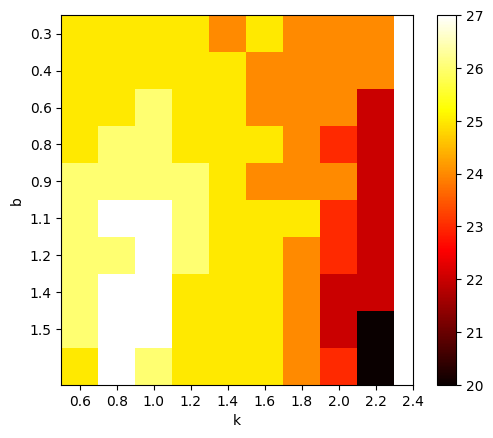

In [165]:
import matplotlib.pyplot as plt

data = kb_sc

plt.imshow(data, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.title('')

plt.xlabel('k')
plt.ylabel('b')

Klabels = ['']

plt.xticks(range(len(K)), [f'{k:.1f}' for k in K])
plt.yticks(range(len(B)), [f'{b:.1f}' for b in B])

# display the heatmap
plt.show()

Here we have plotted corresponding scores different ks and bs

In [172]:
i = np.argmax(kb_sc)
k = K[i % len(B)]
b = B[i // len(B)]
k,b

(0.7999999999999999, 1.05)

#### Results

In [179]:
bm25_scores = bm25(D, Q, Da, Qt, k, b)
# bm25_results = cmap(bm25_scores)
# bm25_results[0:3]

## Evaluation

In [176]:
tfidf_scores

NameError: ignored

In [177]:
bm25_scores

NameError: ignored